# Ignore Warnings

In [1]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Import Libraries


In [2]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from collections import Counter
from utils.textnormalization import Text_Normalization
from utils.machinelearning import machine_learning_model, fit_model
from utils.deeplearning import model_compile, model_fit, lstm_, gru_, bidirectional_lstm, model_evaluate
from utils.plot_model_changes import plot_changes
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import bar_plot
from utils.text_preprocessing import data_words, words_to_index_, index_to_word_, word_counts, text_to_sequence, sequences_padding, one_hot_encoding
from utils.confusion_matrix import confusion_matrix_, confusion_matrix_display
from utils.generate_poitive_negative import generate_poitive_negative
from utils.performance_metrics import accuracy_score, precision_score, sensitivity_score, specificity_score, f1_score, error_rate, performance_metrics_data_frame
from utils.transformers_ import sentiment_analysis_transformers
from utils.model_inference import machine_learning_inference, deep_learning_inference
from utils.word_vector import word_vector_
tokenizer_ = RegexpTokenizer(r'\w+')
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
tf.keras.utils.set_random_seed(1)

# Download Some Packages

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Us

True

# Read Data

In [4]:
Corpus = pd.read_csv('balanced-reviews.txt', sep = "\t",  encoding='utf-16')
Corpus.rename(columns={'review': 'Review'}, inplace=True)
Corpus['Review'] = Corpus['Review'].astype(str)
sentiment = []
for rate in Corpus['rating'].values:
    if rate == 1 or rate == 2:
        sentiment.append('Negative')
    else:
        sentiment.append('Positive')
Corpus['Sentiment'] = sentiment
Corpus = Corpus.sample(frac=1, random_state=1, ignore_index=True)
Corpus.index = Corpus.index + 1 
Corpus.tail(5)

no                           Hotel name  rating    user type  \
105694  194851            إيبس مركز التجارة العالمي       2         أسرة   
105695  382878           ذي بالاس - المدينة القديمة       4  مسافر منفرد   
105696   19399                 فندق المدينة هارموني       2  مسافر منفرد   
105697  301258  فندق راديسون بلو، أبو ظبي جزيرة ياس       5         أسرة   
105698  384991          وردة الرمال للأجنحة الفندقة       2         أسرة   

                                  room type           nights  \
105694                     غرفة قياسية توأم     أقمت 4 ليالي   
105695  غرفة ديلوكس مزدوجة مطلة على البحيرة     أقمت 3 ليالي   
105696                   غرفة قياسية مزدوجة  أقمت ليلة واحدة   
105697           غرفة قياسية مزدوجة أو توأم     أقمت 5 ليالي   
105698                                    -     أقمت 3 ليالي   

                                                   Review Sentiment  
105694  “الفندق 3/10”. الغرف العازلة عن الصوت ( الهدوء...  Negative  
105695  “الموقع جميل”. كل شيء فيه جميل والأسواق قريبة....  Positive  
105696           مخيب للأمل. . خدمات الغرفالاستقبالالمطعم  Negative  
105697              ممتاز. . كان الفطور اقل مستوى من غيره  Positive  
105698  “الشقه متوسطه المستوى ولكن تستحق قيمتها لكبر ح...  Negative

# Validation Data

In [5]:
reviews = [
    "الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.",
    "الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.",
    "الموظفون غير ودودين تمامًا والتعامل كان سيئًا.",
    "الموقع ممتاز قريب من الأماكن السياحية والأسواق.",
    "الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.",
    "حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.",
    "الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.",
    "التصميم الداخلي للفندق مذهل والأجواء مريحة.",
    "الطعام كان سيئًا للغاية وغير نظيف.",
    "الحمام لم يكن نظيفًا ورائحته سيئة.",
    ]
              

# Sentiment Information

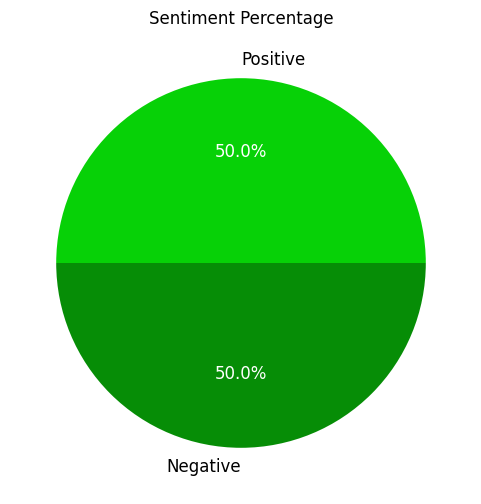

In [6]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

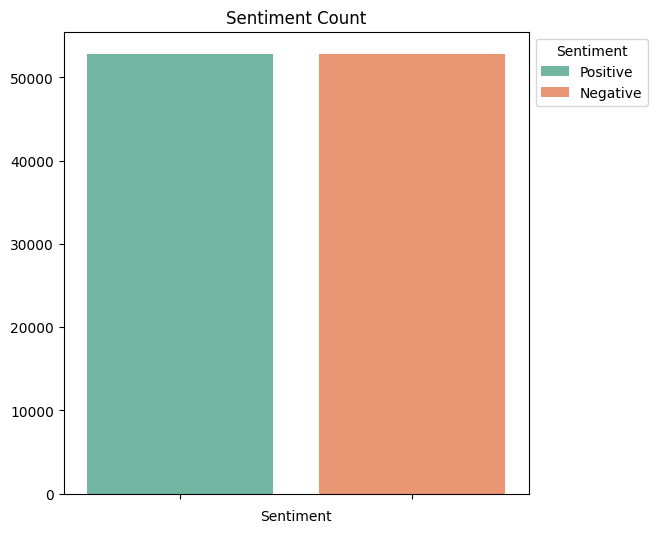

In [7]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [8]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

316380

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

93

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Number Of Words Before Text Normalization

In [12]:
Corpus["Number of Words 1"] = Corpus['Review'].apply(lambda n:len(tokenizer_.tokenize(n)))
Corpus["Number of Words 1"].sum()

2487722

# Average Number Of Words Before Text Normalization

In [13]:
AverageNaumberOfWords1 = int(np.round((Corpus["Number of Words 1"].mean())))
AverageNaumberOfWords1

24

# Maximum Number Of Word Before Text Normalization

In [14]:
MaximumNaumberOfWords1 = Corpus["Number of Words 1"].max()
MaximumNaumberOfWords1

619

# Minimum Number Of Words Before Text Normalization

In [15]:
MimimumNaumberOfWords1 = Corpus["Number of Words 1"].min()
MimimumNaumberOfWords1

0

In [16]:
Corpus[Corpus["Number of Words 1"] == 0]

no                         Hotel name  rating    user type  \
14452  191513  فندق وان تو وان - كونكورد الفجيرة       5          زوج   
25666   60332                بيتي للشقق الفندقية       1            -   
27566  401049                     فندق ورويك دبي       4            -   
51575   86424                   سيتي ماكس الوحدة       5  مسافر منفرد   
54984   32550                فندق سلام الدار مكه       2  مسافر منفرد   
55457  199729                         فندق اسهام       2          زوج   
61830  356041                     فندق سكاى وايز       1         أسرة   
78797  185973                    فندق هيوز بوتيك       5  مسافر منفرد   
78870   28865                  المروج روتانا دبي       5            -   
83999  207647        فندق جميرا في ابراج الاتحاد       1          زوج   
85597  326119                 رست نايت حي المروج       2  مسافر منفرد   

                          room type           nights  \
14452  غرفة سوبيريور مزدوجة أو توأم  أقمت ليلة واحدة   
25666   شقة تنفيذية بغرفة نوم واحدة  أقمت ليلة واحدة   
27566                             -     أقمت 7 ليالي   
51575    غرفة قياسية مزدوجة أو توأم  أقمت ليلة واحدة   
54984                     غرفة توأم  أقمت ليلة واحدة   
55457            غرفة ديلوكس قياسية  أقمت ليلة واحدة   
61830              غرفة قياسية توأم  أقمت ليلة واحدة   
78797          غرفة مزدوجة كلاسيكية     أقمت 5 ليالي   
78870            غرفة توأم كلاسيكية      أقمت ليلتين   
83999              غرفة ديلوكس كينغ     أقمت 3 ليالي   
85597         شقة من غرفة نوم واحدة     أقمت 3 ليالي   

                                   Review Sentiment  NumberOfSentences  \
14452                  “.....”. .... ....  Positive                  2   
25666              “,,,,,,,,,,”. . ,,,,,,  Negative                  3   
27566                           “-”. -. -  Positive                  3   
51575                          “❤️”. 👍. 👆  Positive                  3   
54984  “....”. ............ .............  Negative                  2   
55457                               “. .   Negative                  2   
61830                           “*”. *. *  Negative                  3   
78797                        “👍🏻”. 👍🏻. 👍🏻  Positive                  3   
78870                    “...”. .... ....  Positive                  2   
83999                           “!”. !. !  Negative                  3   
85597                               “. .   Negative                  2   

       Number of Words 1  
14452                  0  
25666                  0  
27566                  0  
51575                  0  
54984                  0  
55457                  0  
61830                  0  
78797                  0  
78870                  0  
83999                  0  
85597                  0

# Number Of Charachters Before Text Normalization

In [17]:
Corpus["Number of Charachters 1"] = Corpus['Review'].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 1"].sum()

11484118

# Average Number Of Charachters Before Text Normalization

In [18]:
AverageNumberOfCharachters1 = int(np.round(Corpus["Number of Charachters 1"].mean()))
AverageNumberOfCharachters1

109

# Maximum Number Of Charachters Before Text Normalization

In [19]:
MaximumNumberOfCharachters1 = Corpus['Number of Charachters 1'].max() 
MaximumNumberOfCharachters1

2705

# Minimum Number Of Charachters Before Text Normalization

In [20]:
MinimumNumberOfCharachters1 = Corpus['Number of Charachters 1'].min() 
MinimumNumberOfCharachters1

0

In [21]:
Corpus[Corpus['Number of Charachters 1']==0]

no                         Hotel name  rating    user type  \
14452  191513  فندق وان تو وان - كونكورد الفجيرة       5          زوج   
21173  366711          أجنحة نوفوتيل الرياض ديار       5         أسرة   
25666   60332                بيتي للشقق الفندقية       1            -   
27566  401049                     فندق ورويك دبي       4            -   
51575   86424                   سيتي ماكس الوحدة       5  مسافر منفرد   
54984   32550                فندق سلام الدار مكه       2  مسافر منفرد   
55457  199729                         فندق اسهام       2          زوج   
61830  356041                     فندق سكاى وايز       1         أسرة   
69219  310639          فندق رامادا شيلسي البرشاء       5         أسرة   
78797  185973                    فندق هيوز بوتيك       5  مسافر منفرد   
78870   28865                  المروج روتانا دبي       5            -   
79644    5966                       العين روتانا       2            -   
83999  207647        فندق جميرا في ابراج الاتحاد       1          زوج   
85597  326119                 رست نايت حي المروج       2  مسافر منفرد   
86807  108689    فندق أبراج الصفوة – دار الغفران       5          زوج   

                                  room type           nights  \
14452          غرفة سوبيريور مزدوجة أو توأم  أقمت ليلة واحدة   
21173  غرفة متميزة مع سرير بحجم كوين وأريكة     أقمت 3 ليالي   
25666           شقة تنفيذية بغرفة نوم واحدة  أقمت ليلة واحدة   
27566                                     -     أقمت 7 ليالي   
51575            غرفة قياسية مزدوجة أو توأم  أقمت ليلة واحدة   
54984                             غرفة توأم  أقمت ليلة واحدة   
55457                    غرفة ديلوكس قياسية  أقمت ليلة واحدة   
61830                      غرفة قياسية توأم  أقمت ليلة واحدة   
69219                                     -     أقمت 7 ليالي   
78797                  غرفة مزدوجة كلاسيكية     أقمت 5 ليالي   
78870                    غرفة توأم كلاسيكية      أقمت ليلتين   
79644                      غرفة كنغ بريميوم  أقمت ليلة واحدة   
83999                      غرفة ديلوكس كينغ     أقمت 3 ليالي   
85597                 شقة من غرفة نوم واحدة     أقمت 3 ليالي   
86807                  غرفة سوبيريور مزدوجة      أقمت ليلتين   

                                   Review Sentiment  NumberOfSentences  \
14452                  “.....”. .... ....  Positive                  2   
21173                              “9. .   Positive                  2   
25666              “,,,,,,,,,,”. . ,,,,,,  Negative                  3   
27566                           “-”. -. -  Positive                  3   
51575                          “❤️”. 👍. 👆  Positive                  3   
54984  “....”. ............ .............  Negative                  2   
55457                               “. .   Negative                  2   
61830                           “*”. *. *  Negative                  3   
69219                             “3 . .   Positive                  2   
78797                        “👍🏻”. 👍🏻. 👍🏻  Positive                  3   
78870                    “...”. .... ....  Positive                  2   
79644                         “4 😑”. . 4😑  Negative                  3   
83999                           “!”. !. !  Negative                  3   
85597                               “. .   Negative                  2   
86807                            “١”. . 2  Positive                  3   

       Number of Words 1  Number of Charachters 1  
14452                  0                        0  
21173                  1                        0  
25666                  0                        0  
27566                  0                        0  
51575                  0                        0  
54984                  0                        0  
55457                  0                        0  
61830                  0                        0  
69219                  1                        0  
78797                  0                        0  
78870                  0                        0  
79644   

# Most Frequent Words Before Text Normalization

In [22]:
MostFrequentWord1 = Counter((Corpus['Review']).str.split().explode()).most_common(15)
MostFrequentWordDF1 = pd.DataFrame(MostFrequentWord1, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF1

Word  Count
1          من  50502
2          في  48501
3      الفندق  33246
4          لا  27415
5           .  26495
6         جدا  25571
7           و  21856
8         غير  18140
9          كل  17111
10        على  15785
11  الاستقبال  15195
12      الغرف  14316
13         شي  13558
14         لم  13302
15       يوجد  11825

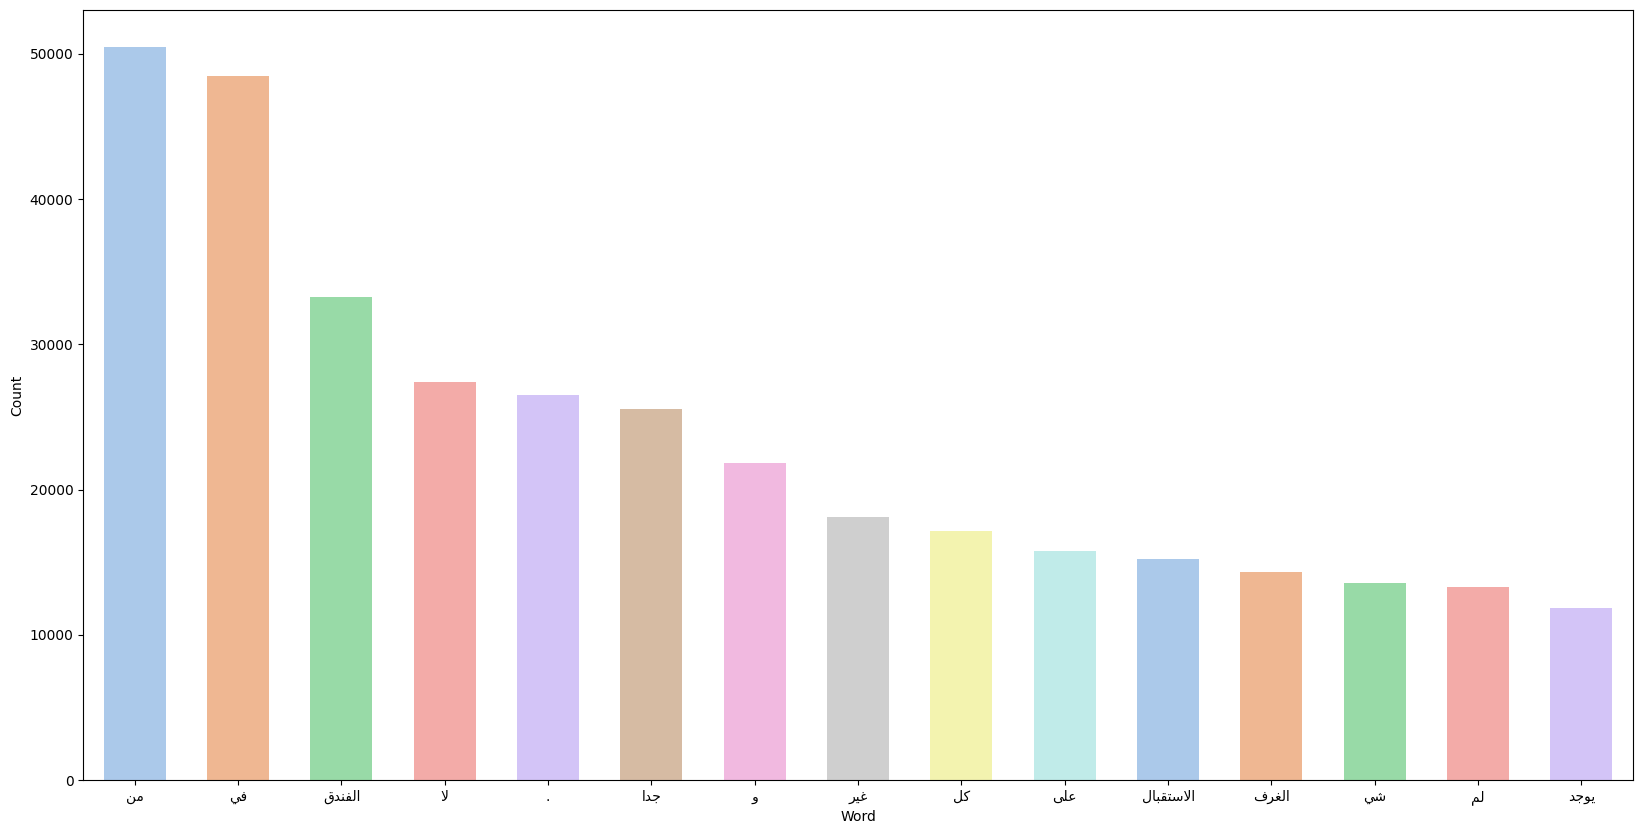

In [23]:
bar_plot(data=MostFrequentWordDF1, text = 'Word', x = 'Word', y='Count')

# Text Normalization

In [24]:
text_normalization = Text_Normalization(remove_emojis = True,
                                        remove_hashtags = True,
                                        remove_url = True,
                                        remove_mention = True,
                                        remove_html_tags = True,
                                        remove_new_line_char = True,
                                        remove_english_letter = True,
                                        remove_stop_words = True,
                                        remove_al = False,
                                        remove_arabic_diacritics = True,
                                        remove_arabic_tatweel = True,
                                        convert_gaf = True,
                                        convert_pe = True,
                                        convert_che = True,
                                        convert_ve = True,
                                        convert_alef = True,
                                        convert_alef_maqsura = True,
                                        convert_teh_marbuta = True,
                                        convert_kurdish_rah = True,
                                        convert_ayin = True,
                                        convert_la = True,
                                        convert_kurdish_tah = True,
                                        convert_kurdish_waw = True,
                                        convert_kurdish_kha = True,
                                        convert_kurdish_ga = True,
                                        remove_greek_letter = True,
                                        remove_hindi_letter = True,
                                        remove_mathematical_operators = True,
                                        remove_cyrillic_letter = True,
                                        remove_latin_letter = True,
                                        remove_currency = True,
                                        remove_punctuations = True,
                                        remove_number = True,
                                        remove_longest_than = True,
                                        remove_duplicate_word = True,
                                        remove_single_letter = True,
                                        remove_duplicated_letter = True,
                                        remove_unwanted_char = True,
                                        normalize_arabic_unicode = True,
                                        remove_unicode_and_special_character = True,
                                        remove_whitespace = True)


In [25]:
Corpus['Normalized_Review'] = Corpus['Review'].map(lambda x: text_normalization.text_normalization(x))
Corpus.dropna(axis=1, inplace=True)
Corpus.to_csv('Normalized Corpus.csv')

In [26]:
text_normalization.text_normalization('الستقبال')

'الستقبال'

# Number Of Unique Words

In [27]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)

len(UniqueWords)

119466

# WordCloud

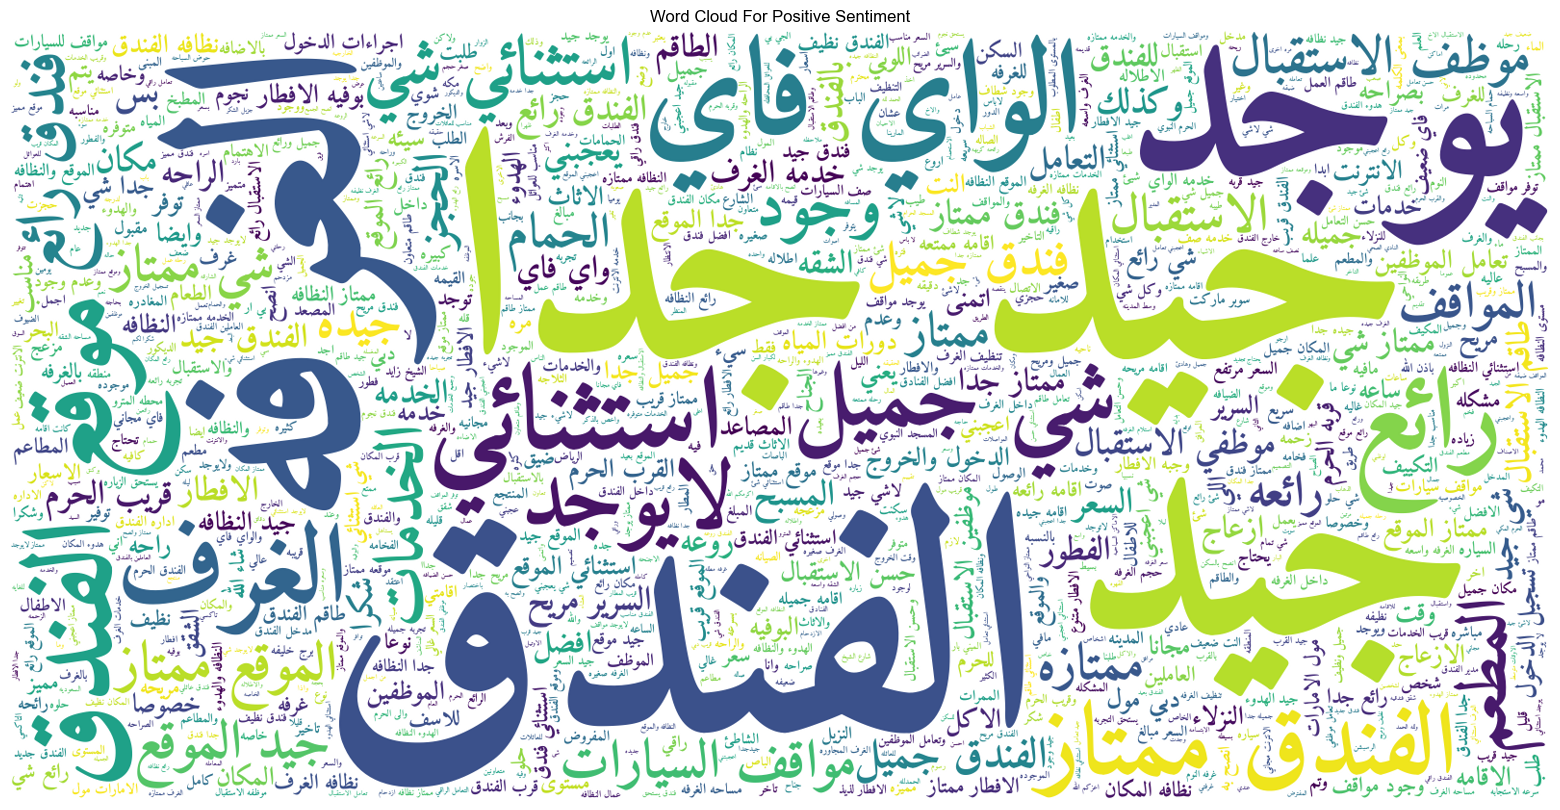

In [28]:
wordcloud(data=Corpus, target='Positive', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

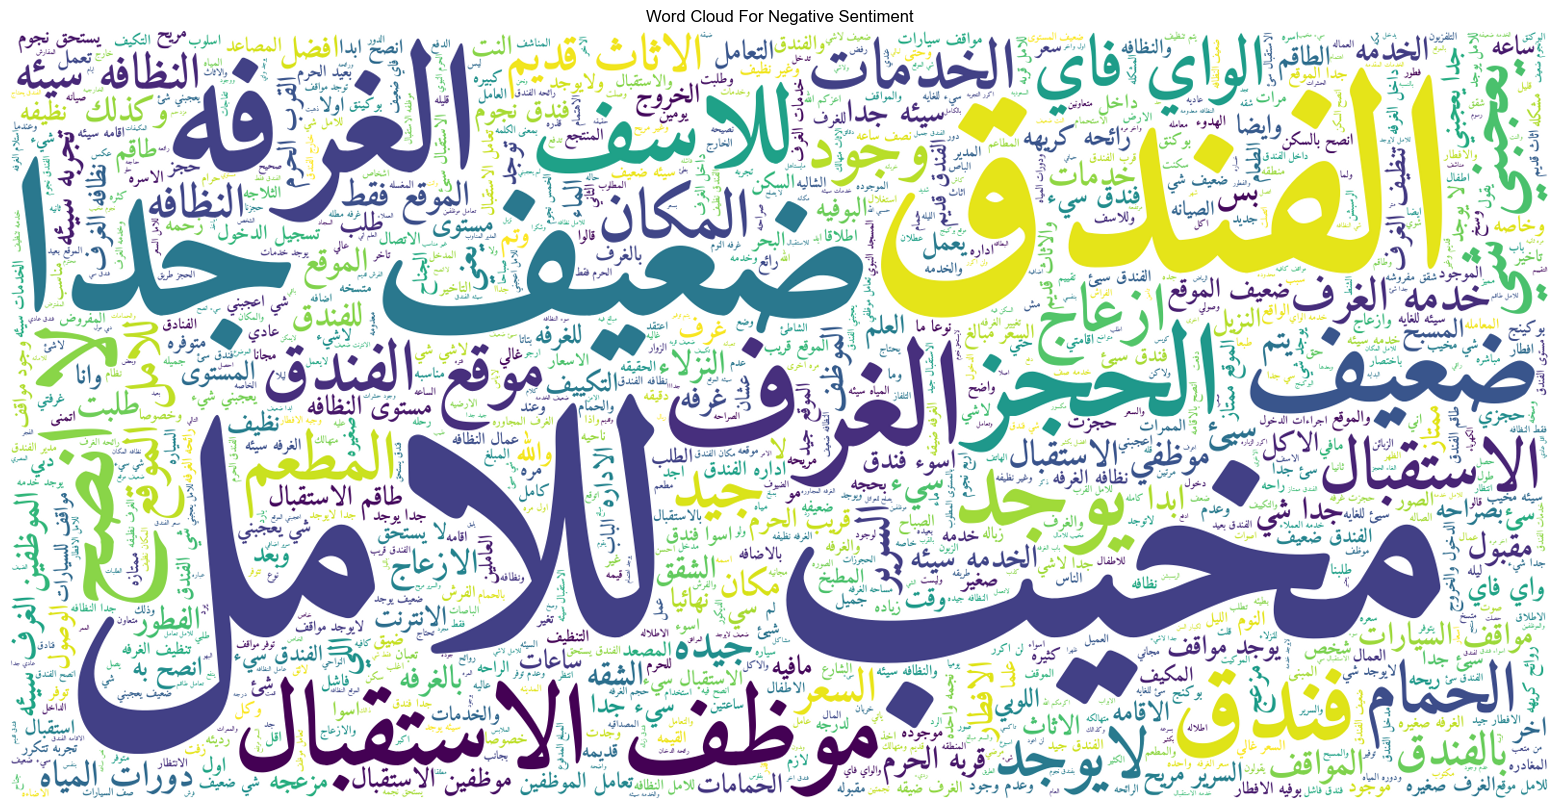

In [29]:
wordcloud(data=Corpus, target='Negative', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

# Number Of Words After Text Normalization

In [30]:
Corpus["Number of Words 2"] = Corpus["Normalized_Review"].apply(lambda n:len(tokenizer_.tokenize(n)))
Corpus.drop(Corpus[Corpus["Number of Words 2"] == 0].index, inplace = True)
Corpus["Number of Words 2"].sum()

1833498

# Average Number Of Words After Text Normalization

In [31]:
AverageNaumberOfWords2 = int(np.round((Corpus["Number of Words 2"].mean())))
AverageNaumberOfWords2

17

# Maximum Number Of Word After Text Normalization

In [32]:
MaximumNaumberOfWords2 = Corpus["Number of Words 2"].max()
MaximumNaumberOfWords2

392

# Minimum Number Of Words After Text Normalization

In [33]:
MimimumNaumberOfWords2 = Corpus["Number of Words 2"].min()
MimimumNaumberOfWords2

1

# Number Of Charachters After Text Normalization

In [34]:
Corpus["Number of Charachters 2"] = Corpus["Normalized_Review"].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 2"].sum()

9664421

# Average Number Of Charachters After Text Normalization

In [35]:
AverageNumberOfCharachters2 = int(np.round(Corpus["Number of Charachters 2"].mean()))
AverageNumberOfCharachters2

91

# Maximum Number Of Charachters After Text Normalization

In [36]:
MaximumNumberOfCharachters2 = Corpus['Number of Charachters 2'].max() 
MaximumNumberOfCharachters2

2049

# Minimum Number Of Charachters After Text Normalization

In [37]:
MinimumNumberOfCharachters2 = Corpus['Number of Charachters 2'].min() 
MinimumNumberOfCharachters2

2

In [38]:
Corpus[Corpus['Number of Charachters 2']==0]

Empty DataFrame
Columns: [no, Hotel name, rating, user type, room type, nights, Review, Sentiment, NumberOfSentences, Number of Words 1, Number of Charachters 1, Normalized_Review, Number of Words 2, Number of Charachters 2]
Index: []

# Most Frequent Words After Text Normalization

In [39]:
MostFrequentWord2 = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF2 = pd.DataFrame(MostFrequentWord2, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF2

Word  Count
1      الفندق  39379
2         جيد  18657
3   الاستقبال  18295
4      الغرفه  17330
5         جدا  17062
6          شي  16575
7       الغرف  15590
8       ممتاز  14972
9        ضعيف  14752
10       فندق  14297
11     الموقع  13802
12       يوجد  12423
13    النظافه  12039
14       سيئه  10031
15       مخيب   9746

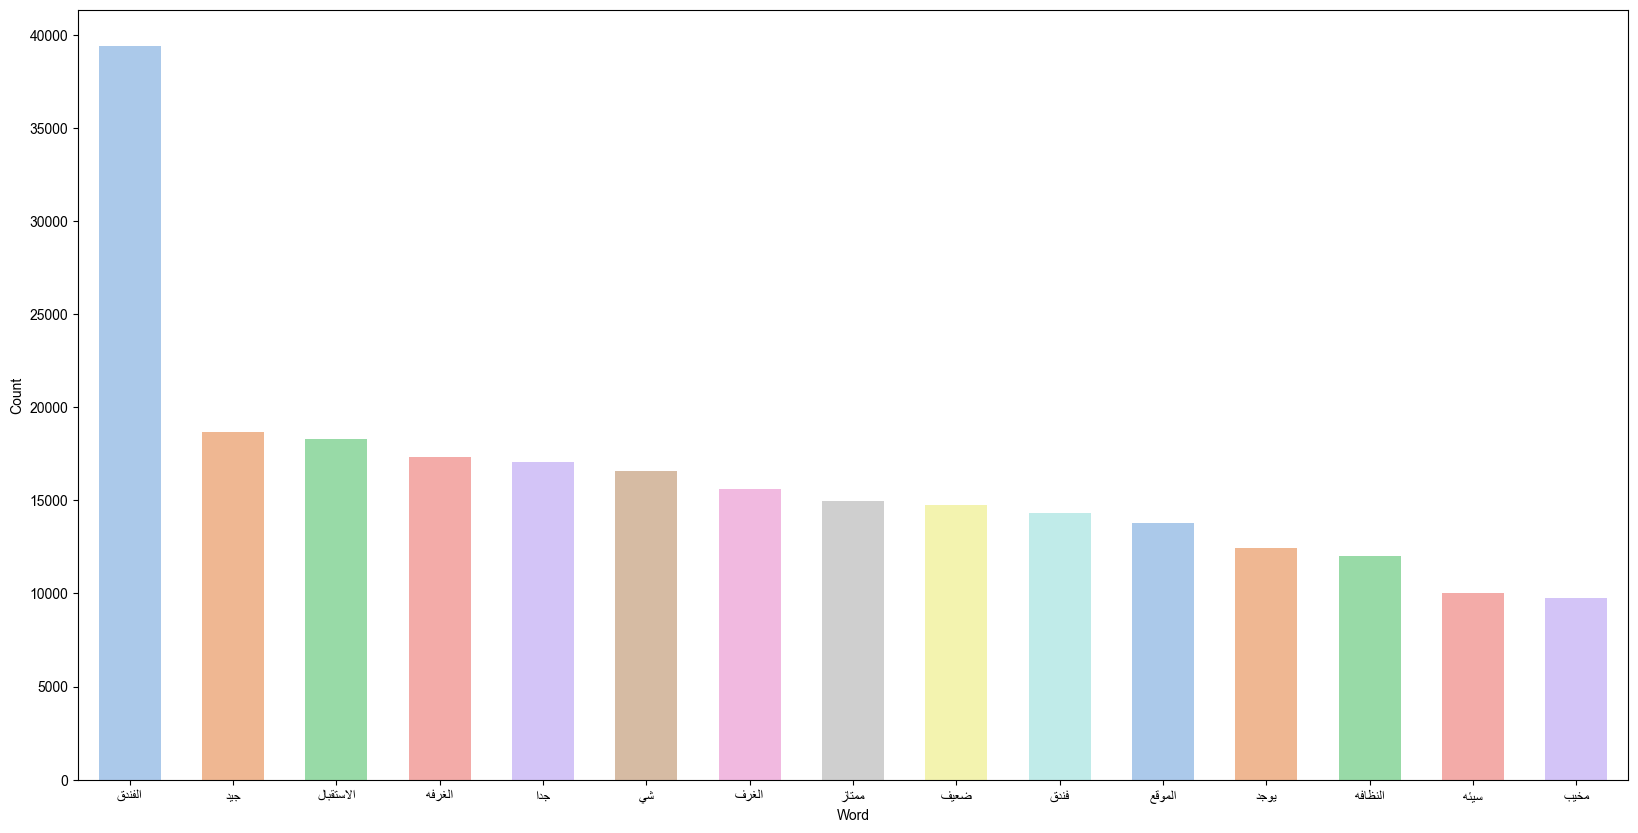

In [40]:
bar_plot(data=MostFrequentWordDF2, x = 'Word', y='Count' , text='Word')

# Most Frequent Words Of Each Sentiment

**1-Positive**

In [41]:
Positive = Corpus[Corpus['Sentiment'] == 'Positive']

In [42]:
PositiveMostFrequentWord = Counter((Positive['Normalized_Review']).str.split().explode()).most_common(10)
PositiveMostFrequentWordDF = pd.DataFrame(PositiveMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
PositiveMostFrequentWordDF

Word  Count
1      الفندق  17657
2         جيد  15058
3       ممتاز  13499
4        رائع   9166
5          شي   8307
6   الاستقبال   7974
7    استثنائي   7339
8         جدا   7257
9      الموقع   6682
10       فندق   6433

**2-Negative**

In [43]:
Negative = Corpus[Corpus['Sentiment'] == 'Negative']

In [44]:
NegativeMostFrequentWord = Counter((Negative['Normalized_Review']).str.split().explode()).most_common(10)
NegativeMostFrequentWordDF = pd.DataFrame(NegativeMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
NegativeMostFrequentWordDF

Word  Count
1      الفندق  21722
2        ضعيف  13698
3      الغرفه  11041
4   الاستقبال  10321
5         جدا   9805
6        مخيب   9743
7       الغرف   9653
8       للامل   9577
9        سيئه   9354
10         شي   8268

# Bigrams

In [45]:
Corpus['Bigrams'] = Corpus['Normalized_Review'].apply(lambda x: list(nltk.bigrams(x.split( ))))
Corpus

no                            Hotel name  rating    user type  \
1       250865              فندق ميلينيوم بلازا دبي‏       5  مسافر منفرد   
2       374645                            فندق تفويج       1  مسافر منفرد   
3       164528  جراند ميد وست تاور - شارع الشيخ زايد       2  مسافر منفرد   
4        73214                  فندق كارلتون المعيبد       2          زوج   
5       134481                        فندق إيلاف بكة       5         أسرة   
...        ...                                   ...     ...          ...   
105694  194851             إيبس مركز التجارة العالمي       2         أسرة   
105695  382878            ذي بالاس - المدينة القديمة       4  مسافر منفرد   
105696   19399                  فندق المدينة هارموني       2  مسافر منفرد   
105697  301258   فندق راديسون بلو، أبو ظبي جزيرة ياس       5         أسرة   
105698  384991           وردة الرمال للأجنحة الفندقة       2         أسرة   

                                  room type           nights  \
1               غرفة بريميوم مزدوجة أو توأم  أقمت ليلة واحدة   
2                       غرفة سوبيريور مفردة     أقمت 3 ليالي   
3                                         -     أقمت 3 ليالي   
4                        غرفة قياسية مزدوجة      أقمت ليلتين   
5                                 غرفة توأم     أقمت 6 ليالي   
...                                     ...              ...   
105694                     غرفة قياسية توأم     أقمت 4 ليالي   
105695  غرفة ديلوكس مزدوجة مطلة على البحيرة     أقمت 3 ليالي   
105696                   غرفة قياسية مزدوجة  أقمت ليلة واحدة   
105697           غرفة قياسية مزدوجة أو توأم     أقمت 5 ليالي   
105698                                    -     أقمت 3 ليالي   

                                                   Review Sentiment  \
1           استثنائي. سرعة إنهاء الإجراءات. اعمال الصيانة  Positive   
2       “سيئ جدً”. . موظف الاستقبال شفت الليل يعاملنا ...  Negative   
3                             ضعيف. . تعاملات الطاقم سيئه  Negative   
4       “اسواء فندق”. فقط الهدواء. الموقع سيء جدا لا ت...  Negative   
5       “فندق مميز”. النظافه الداخليه المطعم. لايوجد و...  Positive   
...                                                   ...       ...   
105694  “الفندق 3/10”. الغرف العازلة عن الصوت ( الهدوء...  Negative   
105695  “الموقع جميل”. كل شيء فيه جميل والأسواق قريبة....  Positive   
105696           مخيب للأمل. . خدمات الغرفالاستقبالالمطعم  Negative   
105697              ممتاز. . كان الفطور اقل مستوى من غيره  Positive   
105698  “الشقه متوسطه المستوى ولكن تستحق قيمتها لكبر ح...  Negative   

        NumberOfSentences  Number of Words 1  Number of Charachters 1  \
1                       3                  6                       38   
2                       3                 63                      248   
3                       3                  4                       21   
4                       3                 63                      281   
5                       3                 10                       48   
...                   ...                ...                      ...   
105694                  3                 32                      126   
105695                  3                 24                      102   
105696                  3                  4                       34   
105697                  3                  7                       28   
105698                  3                112                      520   

                                        Normalized_Review  Number of Words 2  \
1             استثنائي سرعه انهاء الاجراءات اعمال الصيانه                  6   
2       سيئ جد موظف الاستقبال شفت الليل يعاملنا اساس ب...                 48   
3                                ضعيف تعاملات الطاقم سيئه                  4   
4       اسواء فندق الهدواء الموقع سيء توجد مواقف داخل ...                 43   
5       فندق مميز النظافه الداخليه المطعم لايوجد واى ف...                  9   
...                                                   ...                ...   
105694  الفندق الغرف العازله

# Split The Dataset Into Dependent (X) And Independent (y)

In [46]:
X, y= Corpus['Normalized_Review'], Corpus['Sentiment']

# Encoding Dependent Variables (Y) Into Integer

In [47]:
le = LabelEncoder()
y = le.fit_transform(y)

# Split The Dataset Into Training And Testing

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=33,  stratify=y)

# Vectorizer

In [49]:
Vectorizer = TfidfVectorizer()
X_train_Vec = Vectorizer.fit_transform(X_train)
X_test_Vec = Vectorizer.transform(X_test)

# Word Mapping

In [50]:
Word_mapping = Vectorizer.vocabulary_
Word_mapping_ =pd.DataFrame((list(Word_mapping.items())), columns=['Word', 'Mapping'])
Word_mapping_.head()

Word  Mapping
0   الخدمات    11914
1   ناقصههه    80791
2  والاعامل    85757
3        سي    50093
4     كانهم    60875

# Machine Learning

**1-Naive Bayes**

In [51]:
Algorithm = MultinomialNB(alpha= 1)
model_1 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_1, X_train=X_train_Vec, y_train=y_train)

MultinomialNB(alpha=1)

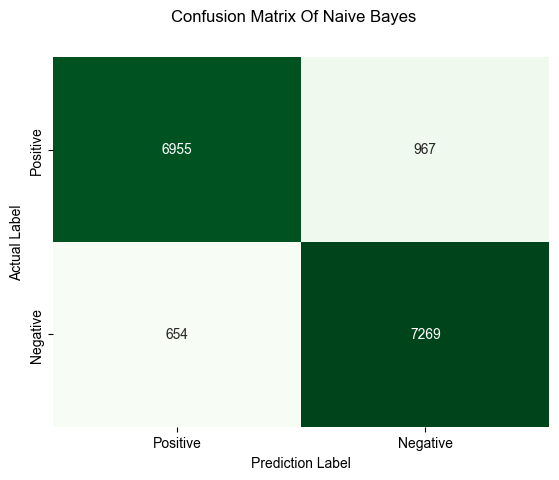

In [52]:
y_predNB = model_1.predict(X_test_Vec)
ConfusionMatrixNB = confusion_matrix_(y_test = y_test, y_pred = y_predNB)
confusion_matrix_display(confusion_matrix = ConfusionMatrixNB, name = 'Naive Bayes')
False_PositiveNB, True_PositiveNB, False_NegativeNB, True_NegativeNB = generate_poitive_negative(ConfusionMatrixNB)

In [53]:
AccuracyNB = accuracy_score(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)
PrecisionNB= precision_score(True_Positive = True_PositiveNB, False_Positive= False_PositiveNB)

SensitivityNB = sensitivity_score(True_Positive = True_PositiveNB,  False_Negative = False_NegativeNB)
SpecificityNB = specificity_score(True_Negative = True_NegativeNB, False_Positive = False_PositiveNB)

F1ScoreNB = f1_score(True_Positive = True_PositiveNB, False_Negative = False_NegativeNB, False_Positive = False_PositiveNB)
ErrorNB = error_rate(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)

In [54]:
performance_metrics_data_frame(Accuracy = AccuracyNB, Precision = PrecisionNB, Sensitivity = SensitivityNB, Specificity = SpecificityNB, F1Score = F1ScoreNB, Error = ErrorNB)

Values
Accuracy     0.897696
Precision    0.877935
Sensitivity  0.914049
Specificity  0.882589
F1Score      0.895628
Error        0.102304

**2-Logistic Regression**

In [55]:
Algorithm = LogisticRegression()
model_2 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_2, X_train=X_train_Vec, y_train=y_train)

LogisticRegression()

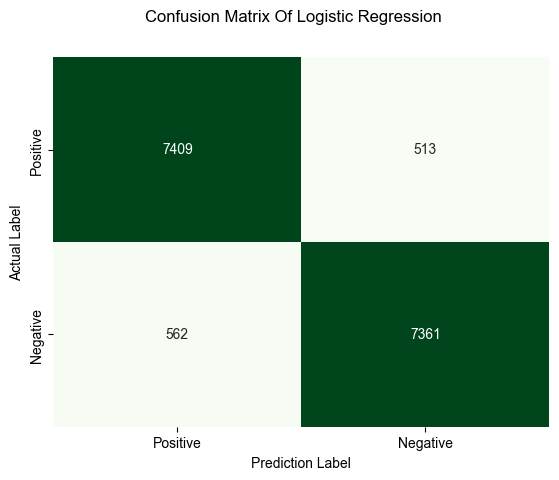

In [56]:
y_predLR = model_2.predict(X_test_Vec)
ConfusionMatrixLR = confusion_matrix_(y_test = y_test, y_pred = y_predLR)
confusion_matrix_display(confusion_matrix = ConfusionMatrixLR, name = 'Logistic Regression')
False_PositiveLR, True_PositiveLR, False_NegativeLR, True_NegativeLR = generate_poitive_negative(ConfusionMatrixLR)

In [57]:
AccuracyLR = accuracy_score(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)
PrecisionLR= precision_score(True_Positive = True_PositiveLR, False_Positive= False_PositiveLR)

SensitivityLR = sensitivity_score(True_Positive = True_PositiveLR,  False_Negative = False_NegativeLR)
SpecificityLR = specificity_score(True_Negative = True_NegativeLR, False_Positive = False_PositiveLR)

F1ScoreLR = f1_score(True_Positive = True_PositiveLR, False_Negative = False_NegativeLR, False_Positive = False_PositiveLR)
ErrorLR = error_rate(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)

In [58]:
performance_metrics_data_frame(Accuracy = AccuracyLR, Precision = PrecisionLR, Sensitivity = SensitivityLR, Specificity = SpecificityLR, F1Score = F1ScoreLR, Error = ErrorLR)

Values
Accuracy     0.932155
Precision    0.935244
Sensitivity  0.929494
Specificity  0.934849
F1Score      0.932360
Error        0.067845

**3-Decision Tree**

In [59]:
Algorithm = DecisionTreeClassifier(criterion='gini', )
model_3 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_3, X_train=X_train_Vec, y_train=y_train)

DecisionTreeClassifier()

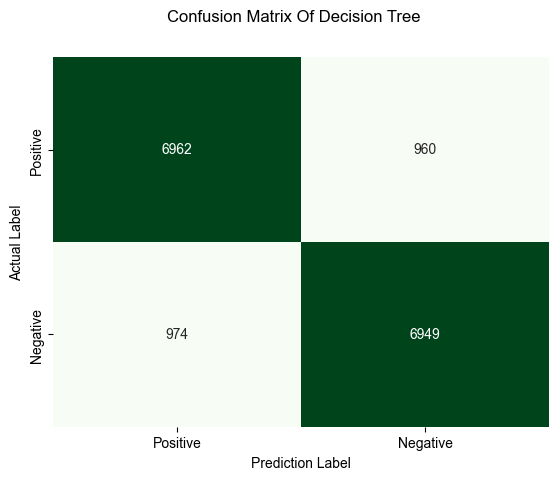

In [60]:
y_predDT = model_3.predict(X_test_Vec)
ConfusionMatrixDT = confusion_matrix_(y_test = y_test, y_pred = y_predDT)
confusion_matrix_display(confusion_matrix = ConfusionMatrixDT, name = 'Decision Tree')
False_PositiveDT, True_PositiveDT, False_NegativeDT, True_NegativeDT = generate_poitive_negative(ConfusionMatrixDT)

In [61]:
AccuracyDT = accuracy_score(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)
PrecisionDT= precision_score(True_Positive = True_PositiveDT, False_Positive =False_PositiveDT)

SensitivityDT = sensitivity_score(True_Positive = True_PositiveDT,  False_Negative = False_NegativeDT)
SpecificityDT = specificity_score(True_Negative = True_NegativeDT, False_Positive = False_PositiveDT)

F1ScoreDT = f1_score(True_Positive = True_PositiveDT, False_Negative = False_NegativeDT, False_Positive = False_PositiveDT)
ErrorDT = error_rate(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)

In [62]:
performance_metrics_data_frame(Accuracy = AccuracyDT, Precision = PrecisionDT, Sensitivity = SensitivityDT, Specificity = SpecificityDT, F1Score = F1ScoreDT, Error = ErrorDT)

Values
Accuracy     0.877943
Precision    0.878818
Sensitivity  0.877268
Specificity  0.878619
F1Score      0.878043
Error        0.122057

**4-K Nearest Neighbors**

In [63]:
Algorithm =KNeighborsClassifier(metric='minkowski', n_neighbors=5, weights='distance', p=2)
model_4 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_4, X_train=X_train_Vec, y_train=y_train)

KNeighborsClassifier(weights='distance')

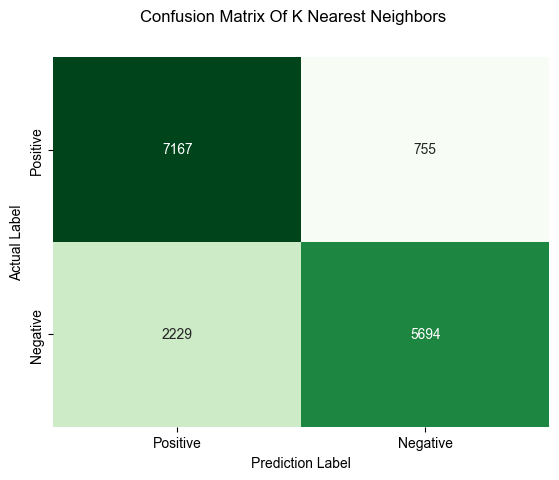

In [64]:
y_predKNN = model_4.predict(X_test_Vec)
ConfusionMatrixKNN = confusion_matrix_(y_test = y_test, y_pred = y_predKNN)
confusion_matrix_display(confusion_matrix = ConfusionMatrixKNN, name = 'K Nearest Neighbors')
False_PositiveKNN, True_PositiveKNN, False_NegativeKNN, True_NegativeKNN = generate_poitive_negative(ConfusionMatrixKNN)

In [65]:
AccuracyKNN = accuracy_score(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)
PrecisionKNN= precision_score(True_Positive = True_PositiveKNN, False_Positive =False_PositiveKNN)

SensitivityKNN = sensitivity_score(True_Positive = True_PositiveKNN,  False_Negative = False_NegativeKNN)
SpecificityKNN = specificity_score(True_Negative = True_NegativeKNN, False_Positive = False_PositiveKNN)

F1ScoreKNN = f1_score(True_Positive = True_PositiveKNN, False_Negative = False_NegativeKNN, False_Positive = False_PositiveKNN)
ErrorKNN = error_rate(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)

In [66]:
performance_metrics_data_frame(Accuracy = AccuracyKNN, Precision = PrecisionKNN, Sensitivity = SensitivityKNN, Specificity = SpecificityKNN, F1Score = F1ScoreKNN, Error = ErrorKNN)

Values
Accuracy     0.811676
Precision    0.904696
Sensitivity  0.762771
Specificity  0.882928
F1Score      0.827694
Error        0.188324

**5-Random Forest**

In [67]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=100, )
model_5 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_5, X_train=X_train_Vec, y_train=y_train)

RandomForestClassifier(criterion='entropy')

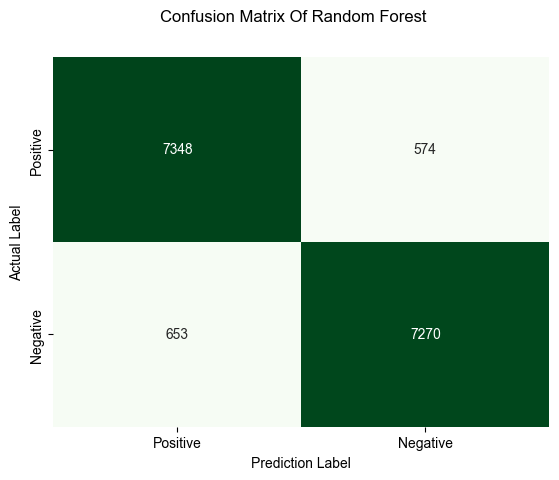

In [68]:
y_predRF = model_5.predict(X_test_Vec)
ConfusionMatrixRF = confusion_matrix_(y_test = y_test, y_pred = y_predRF)
confusion_matrix_display(confusion_matrix = ConfusionMatrixRF, name = 'Random Forest')
False_PositiveRF, True_PositiveRF, False_NegativeRF, True_NegativeRF = generate_poitive_negative(ConfusionMatrixRF)

In [69]:
AccuracyRF = accuracy_score(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)
PrecisionRF= precision_score(True_Positive = True_PositiveRF, False_Positive =False_PositiveRF)

SensitivityRF = sensitivity_score(True_Positive = True_PositiveRF,  False_Negative = False_NegativeRF)
SpecificityRF = specificity_score(True_Negative = True_NegativeRF, False_Positive = False_PositiveRF)

F1ScoreRF = f1_score(True_Positive = True_PositiveRF, False_Negative = False_NegativeRF, False_Positive = False_PositiveRF)
ErrorRF = error_rate(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)

In [70]:
performance_metrics_data_frame(Accuracy = AccuracyRF, Precision = PrecisionRF, Sensitivity = SensitivityRF, Specificity = SpecificityRF, F1Score = F1ScoreRF, Error = ErrorRF)

Values
Accuracy     0.922562
Precision    0.927544
Sensitivity  0.918385
Specificity  0.926823
F1Score      0.922942
Error        0.077438

**6-SGD Classifier**

In [71]:
Algorithm = SGDClassifier(loss='hinge', )
model_6 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_6, X_train=X_train_Vec, y_train=y_train)

SGDClassifier()

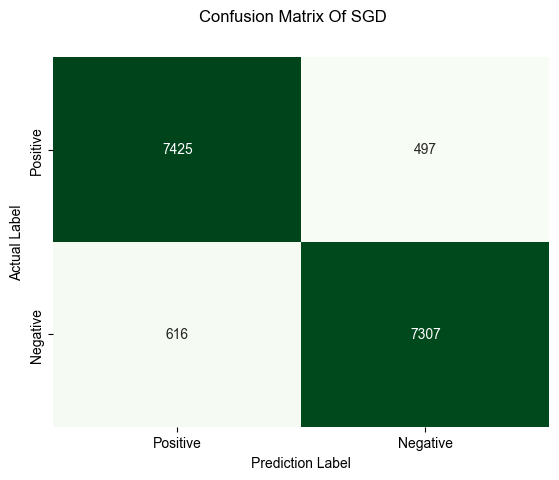

In [72]:
y_predSGD = model_6.predict(X_test_Vec)
ConfusionMatrixSGD = confusion_matrix_(y_test = y_test, y_pred = y_predSGD)
confusion_matrix_display(confusion_matrix = ConfusionMatrixSGD, name = 'SGD')
False_PositiveSGD, True_PositiveSGD, False_NegativeSGD, True_NegativeSGD = generate_poitive_negative(ConfusionMatrixSGD)

In [73]:
AccuracySGD = accuracy_score(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)
PrecisionSGD= precision_score(True_Positive = True_PositiveSGD, False_Positive =False_PositiveSGD)

SensitivitySGD = sensitivity_score(True_Positive = True_PositiveSGD,  False_Negative = False_NegativeSGD)
SpecificitySGD = specificity_score(True_Negative = True_NegativeSGD, False_Positive = False_PositiveSGD)

F1ScoreSGD = f1_score(True_Positive = True_PositiveSGD, False_Negative = False_NegativeSGD, False_Positive = False_PositiveSGD)
ErrorSGD = error_rate(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)

In [74]:
performance_metrics_data_frame(Accuracy = AccuracySGD, Precision = PrecisionSGD, Sensitivity = SensitivitySGD, Specificity = SpecificitySGD, F1Score = F1ScoreSGD, Error = ErrorSGD)

Values
Accuracy     0.929757
Precision    0.937263
Sensitivity  0.923393
Specificity  0.936315
F1Score      0.930276
Error        0.070243

# Deep Learning

**1-Word To Integer (Tokenizer)**

In [75]:
all_words , words = data_words(data=(X_train.to_list() + X_test.to_list())) # Set With Unique Words And Find Number Of Unique Words
words_to_index = words_to_index_(words=words) # Convert Word To Integer Index
index_to_words = index_to_word_(words=words)
all_words

119468

**2-Data To Sequence**

In [76]:
X_train_sequences = text_to_sequence(word_index=words_to_index, data=X_train) # Convert Text Into Squences Of Integer
X_test_sequences = text_to_sequence(word_index=words_to_index, data=X_test) # Convert Text Into Squences Of Integer
max_length = len(max(X_train_sequences, key = len)) # Find Max Length

**3-Zero Padding**

In [77]:
encoded_X_train = sequences_padding(input_sequence=X_train_sequences, max_length=max_length, padding='pre') # Zero Padding (Add Zeros To Strat Of Sequence In Input Sequences To Make All Sequences In Same Length)
encoded_X_test = sequences_padding(input_sequence=X_test_sequences, max_length=max_length, padding='pre') # Zero Padding (Add Zeros To Strat Of Sequence In Input Sequences To Make All Sequences In Same Length)

In [78]:
print('The Vocab Size Is :', all_words)
print('')
print('The Max Length Is :', max_length)

The Vocab Size Is : 119468

The Max Length Is : 392


**4.Word Index**

In [79]:
Word_Index_ =pd.DataFrame(words_to_index.values(),  index = words_to_index.keys(), columns=['Index'])  

**5-Word Occurrence**

In [80]:
word_count = word_counts(data=(X_train.to_list() + X_test.to_list())) # Number Of Occurrence Each Word
word_count_ =pd.DataFrame((list(word_count.items())), columns=['Word', 'Count'])
word_count_.head()

Word  Count
0     الفندق  39379
1        جيد  18657
2  الاستقبال  18295
3     الغرفه  17330
4        جدا  17062

**6-Word Vector**

In [81]:
path = 'full_grams_cbow_100_twitter.mdl'
embedding_dim, word_vector = word_vector_(model_path = path, all_words = all_words , word_index = words_to_index)

# Deep Learing Models

**7-LSTM**

I0000 00:00:1746478991.676868 2462916 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746478991.677167 2462916 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 113s 40ms/step - accuracy: 0.9017 - loss: 0.2405 - val_accuracy: 0.9385 - val_loss: 0.1613 - learning_rate: 0.0010
Epoch 2/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 112s 40ms/step - accuracy: 0.9423 - loss: 0.1569 - val_accuracy: 0.9430 - val_loss: 0.1535 - learning_rate: 0.0010
Epoch 3/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 110s 39ms/step - accuracy: 0.9479 - loss: 0.1422 - val_accuracy: 0.9429 - val_loss: 0.1544 - learning_rate: 0.0010
Epoch 4/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 110s 39ms/step - accuracy: 0.9537 - loss: 0.1294 - val_accuracy: 0.9416 - val_loss: 0.1594 - learning_rate: 0.0010
Epoch 5/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 111s 39ms/step - accuracy: 0.9573 - loss: 0.1194 - val_accuracy: 0.9408 - val_loss: 0.1654 - learning_rate: 0.0010
Test loss: 0.1534881889820099
Test accuracy: 0.9430103898048401


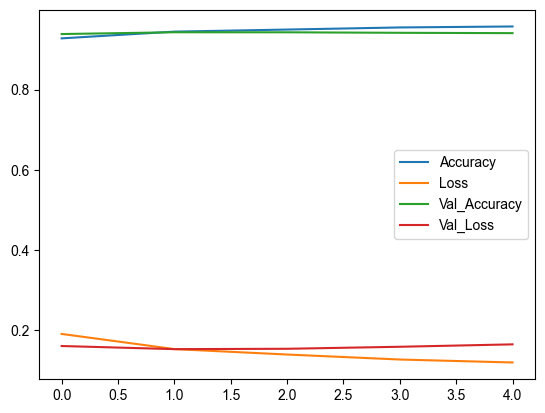

In [82]:
model_7 =lstm_(vocab_size = all_words , embedding_dim = embedding_dim, max_length=max_length, units = 64, embeddings_matrix=word_vector)
model_compile(model=model_7)
history = model_fit(model=model_7, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_7, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)       

**8-Bidirectional LSTM**

Epoch 1/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 192s 68ms/step - accuracy: 0.8988 - loss: 0.2428 - val_accuracy: 0.9383 - val_loss: 0.1630 - learning_rate: 0.0010
Epoch 2/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 189s 67ms/step - accuracy: 0.9413 - loss: 0.1581 - val_accuracy: 0.9428 - val_loss: 0.1553 - learning_rate: 0.0010
Epoch 3/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 191s 68ms/step - accuracy: 0.9472 - loss: 0.1435 - val_accuracy: 0.9405 - val_loss: 0.1581 - learning_rate: 0.0010
Epoch 4/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 190s 68ms/step - accuracy: 0.9531 - loss: 0.1313 - val_accuracy: 0.9399 - val_loss: 0.1606 - learning_rate: 0.0010
Epoch 5/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 190s 68ms/step - accuracy: 0.9574 - loss: 0.1204 - val_accuracy: 0.9397 - val_loss: 0.1608 - learning_rate: 0.0010
Test loss: 0.15529416501522064
Test accuracy: 0.9427579641342163


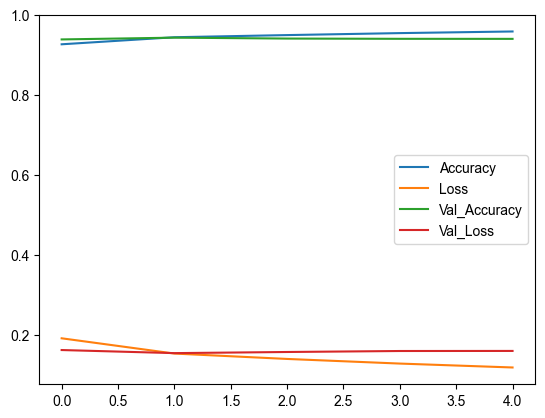

In [83]:
model_8 = bidirectional_lstm(vocab_size =all_words, embedding_dim = embedding_dim, max_length=max_length, units = 64, embeddings_matrix=word_vector)
model_compile(model=model_8)
history = model_fit(model=model_8, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_8, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)

**9-GRU**

Epoch 1/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 107s 38ms/step - accuracy: 0.8807 - loss: 0.2619 - val_accuracy: 0.9402 - val_loss: 0.1589 - learning_rate: 0.0010
Epoch 2/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 105s 37ms/step - accuracy: 0.9435 - loss: 0.1536 - val_accuracy: 0.9429 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 3/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 105s 37ms/step - accuracy: 0.9491 - loss: 0.1396 - val_accuracy: 0.9429 - val_loss: 0.1608 - learning_rate: 0.0010
Epoch 4/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 104s 37ms/step - accuracy: 0.9540 - loss: 0.1280 - val_accuracy: 0.9412 - val_loss: 0.1697 - learning_rate: 0.0010
Epoch 5/10
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 103s 37ms/step - accuracy: 0.9586 - loss: 0.1166 - val_accuracy: 0.9359 - val_loss: 0.1906 - learning_rate: 0.0010
Test loss: 0.1567935198545456
Test accuracy: 0.9428842067718506


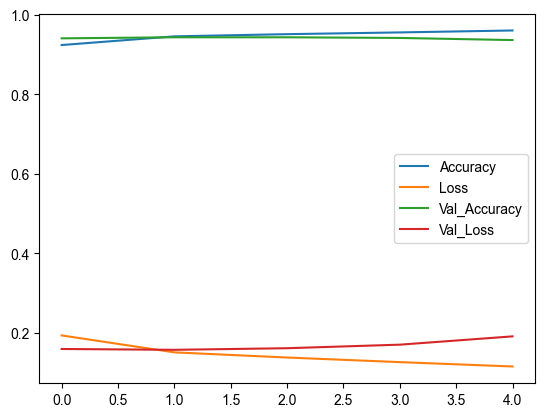

In [84]:
model_9 = gru_(vocab_size = all_words, embedding_dim = embedding_dim, max_length=max_length, units = 64, embeddings_matrix=word_vector)
model_compile(model=model_9)
history = model_fit(model=model_9, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_9, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)

# Model Inference

**1-Naive Bayes**

In [85]:
machine_learning_inference(model=model_1,vectorizer=Vectorizer, text = reviews)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Negative

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



**2-Logistic Regression**

In [86]:
machine_learning_inference(model=model_2,vectorizer=Vectorizer, text = reviews)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Negative

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



**3-Decision Tree**

In [87]:
machine_learning_inference(model=model_3,vectorizer=Vectorizer, text = reviews)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Negative

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Negative

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



**4-K Nearest Neighbors**

In [88]:
machine_learning_inference(model=model_4,vectorizer=Vectorizer, text = reviews)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Positive

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Positive

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



**5-Random Forest**

In [89]:
machine_learning_inference(model=model_5,vectorizer=Vectorizer, text = reviews)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Negative

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



**6-SGD Classifier**

In [90]:
machine_learning_inference(model=model_6,vectorizer=Vectorizer, text = reviews)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Negative

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



**7-LSTM**

In [91]:
deep_learning_inference(model = model_7, text = reviews, max_length = max_length, word_index = words_to_index)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Positive

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Negative

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



**8-Bidirectional LSTM**

In [92]:
deep_learning_inference(model = model_8, text = reviews, max_length = max_length, word_index = words_to_index)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Positive

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



**9-GRU**

In [93]:
deep_learning_inference(model = model_9, text = reviews, max_length = max_length, word_index = words_to_index)

Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Positive

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative



# Transformers

In [95]:
sentiment_analysis_transformers(reviews)

Device set to use mps:0


Review: الغرف كانت نظيفة ومريحة ولكن خدمة الغرف بطيئة للغاية.
Sentiment: Negative

Review: الإفطار كان متنوعًا ولذيذًا، سأعود مرة أخرى بالتأكيد.
Sentiment: Positive

Review: الموظفون غير ودودين تمامًا والتعامل كان سيئًا.
Sentiment: Negative

Review: الموقع ممتاز قريب من الأماكن السياحية والأسواق.
Sentiment: Positive

Review: الخدمة كانت ممتازة جدًا والغرف نظيفة ومريحة للغاية.
Sentiment: Positive

Review: حمام السباحة جميل جدًا ونظيف، استمتعنا كثيرًا.
Sentiment: Positive

Review: الموظفون كانوا ودودين ومتعاونين، وتجربتي كانت رائعة.
Sentiment: Positive

Review: التصميم الداخلي للفندق مذهل والأجواء مريحة.
Sentiment: Positive

Review: الطعام كان سيئًا للغاية وغير نظيف.
Sentiment: Negative

Review: الحمام لم يكن نظيفًا ورائحته سيئة.
Sentiment: Negative

